In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from datasets import load_from_disk

tokenized_train = load_from_disk('/content/drive/MyDrive/tokenized_train')
tokenized_val = load_from_disk('/content/drive/MyDrive/tokenized_val')
tokenized_test = load_from_disk('/content/drive/MyDrive/tokenized_test')

/usr/local/lib/python3.11/dist-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by promote_options='default'.
  table = cls._concat_blocks(blocks, axis=0)


In [3]:
print(tokenized_train.column_names)
print(tokenized_val.column_names)
print(tokenized_test.column_names)

['labels', 'input_ids', 'attention_mask']
['labels', 'input_ids', 'attention_mask']
['labels', 'input_ids', 'attention_mask']


In [4]:
from datasets import Value

tokenized_train = tokenized_train.cast_column("labels", Value("int64"))
tokenized_val = tokenized_val.cast_column("labels", Value("int64"))
tokenized_test = tokenized_test.cast_column("labels", Value("int64"))

Casting the dataset:   0%|          | 0/2880000 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/720000 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/400000 [00:00<?, ? examples/s]

In [5]:
tokenized_train = tokenized_train.map(lambda x: {'labels': x['labels'] - 1})
tokenized_val = tokenized_val.map(lambda x: {'labels': x['labels'] - 1})
tokenized_test = tokenized_test.map(lambda x: {'labels': x['labels'] - 1})

Map:   0%|          | 0/2880000 [00:00<?, ? examples/s]

Map:   0%|          | 0/720000 [00:00<?, ? examples/s]

Map:   0%|          | 0/400000 [00:00<?, ? examples/s]

In [4]:
pip install numpy==1.26

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.5/58.5 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 106.0 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.0 which is incompatible.


In [6]:
import numpy as np
print(np.__version__)

1.26.0


In [7]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [8]:
small_train = tokenized_train.shuffle(seed=42).select(range(5000))
small_val = tokenized_val.shuffle(seed=42).select(range(1000))
small_test = tokenized_test.shuffle(seed=42).select(range(1000))

In [9]:
print(np.unique(small_val['labels']))
print(np.unique(small_train['labels']))
print(np.unique(small_test['labels']))

[0 1]
[0 1]
[0 1]


In [10]:
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments

model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=2   # change to actual number of classes if not binary
)

for param in model.base_model.parameters():                # Freezing the backbone transformer
    param.requires_grad = False


training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=15,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    logging_dir="./logs",
    logging_steps=100,
    load_best_model_at_end=True,
    report_to=[]
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train,
    eval_dataset=small_val
)

trainer.train()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,0.449800,0.403576
2,0.357500,0.344640
3,0.339800,0.322882
4,0.314100,0.313090
5,0.318000,0.315180
6,0.290700,0.321986
7,0.299800,0.302812
8,0.335300,0.302453
9,0.297800,0.300249
10,0.294200,0.298698


TrainOutput(global_step=4695, training_loss=0.3263212823512328, metrics={'train_runtime': 535.949, 'train_samples_per_second': 139.939, 'train_steps_per_second': 8.76, 'total_flos': 2483763724800000.0, 'train_loss': 0.3263212823512328, 'epoch': 15.0})

In [11]:
trainer.evaluate()

{'eval_loss': 0.2973356246948242,
 'eval_runtime': 3.4217,
 'eval_samples_per_second': 292.25,
 'eval_steps_per_second': 9.352,
 'epoch': 15.0}

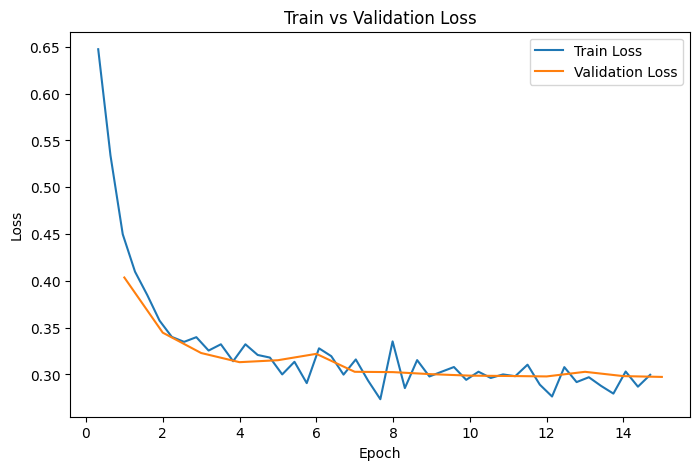

In [12]:
import matplotlib.pyplot as plt
import pandas as pd

logs = trainer.state.log_history
logs_df = pd.DataFrame(logs)

plt.figure(figsize=(8, 5))
plt.plot(logs_df['epoch'][logs_df['loss'].notnull()], logs_df['loss'][logs_df['loss'].notnull()], label='Train Loss')
plt.plot(logs_df['epoch'][logs_df['eval_loss'].notnull()], logs_df['eval_loss'][logs_df['eval_loss'].notnull()], label='Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()
plt.show()

In [13]:
predictions_output = trainer.predict(small_test)
y_pred_logits = predictions_output.predictions
y_true = predictions_output.label_ids
y_pred = np.argmax(y_pred_logits, axis=1)

In [14]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.88      0.87       487
           1       0.88      0.87      0.88       513

    accuracy                           0.88      1000
   macro avg       0.88      0.88      0.88      1000
weighted avg       0.88      0.88      0.88      1000



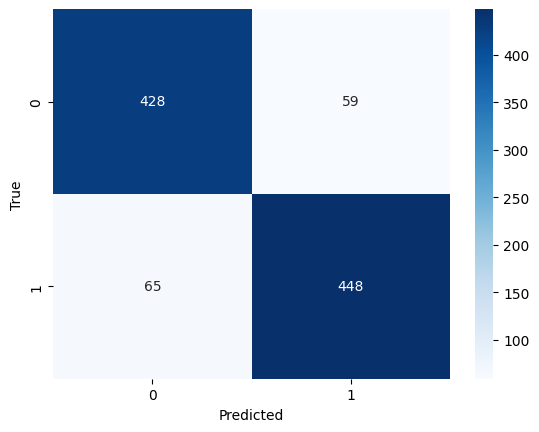

In [15]:
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score

y_score = y_pred_logits[:, 1]

roc_auc = roc_auc_score(y_true, y_score)
print(f"ROC AUC: {roc_auc:.4f}")

ROC AUC: 0.9350


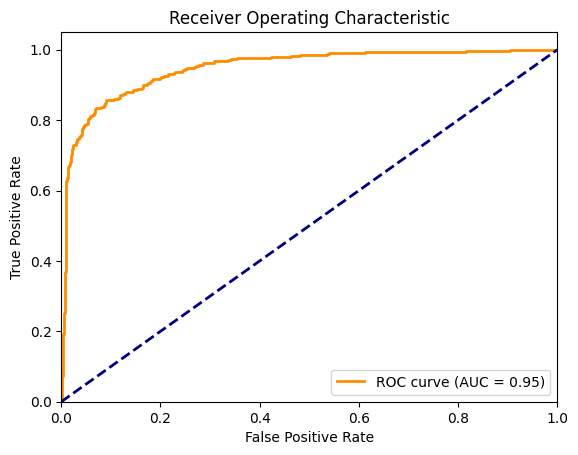

In [16]:
y_score = y_pred_logits[:, 1]

fpr, tpr, thresholds = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # diagonal
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.show()